In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import time
import re

seed = 101

read and clear

In [ ]:
train = pd.read_csv('clear.csv')

In [ ]:
# For beginning, transform train['FullDescription'] to lowercase using text.lower()
train['overview'].str.lower()
train['overview'].fillna('nan', inplace=True)

# Then replace everything except the letters and numbers in the spaces.
# it will facilitate the further division of the text into words.
train['overview'].replace('[^a-zA-Z0-9]', ' ', regex = True)

# Convert a collection of raw documents to a matrix of TF-IDF features with TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(train['overview']) 

# The target value (algorithm has to predict) is SalaryNormalized
y = train['vote_average']

split for train and test

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
print(len(y_train))
print(len(y_test))

157527
39382


baseline

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

get predict

In [ ]:
y_pred = reg.predict(X_test)

get metric

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

2.3663114319822673

**Hypothesis**

1 - Random forest: max depth = 2

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
mean_squared_error(y_test, regr.predict(X_test), squared=False)

1.6524201625202304

 2 - Random forest cycle for max depth: from 2 to 8.

In [ ]:
pipeline = Pipeline([
    ('forest', RandomForestRegressor())
])

parametrs = { #'forest__n_estimators': range (10, 51, 10),
              'forest__max_depth': range (2,9, 2),}

CV = GridSearchCV(pipeline, param_grid=parametrs, scoring='neg_root_mean_squared_error')
CV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('forest',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                  

In [ ]:
print(CV.cv_results_) 

{'mean_fit_time': array([ 84.13946323, 174.57653608, 290.1430181 , 376.04827609]), 'std_fit_time': array([1.98655647, 3.34694395, 5.3883919 , 2.52031962]), 'mean_score_time': array([0.42710333, 0.43571687, 0.44327984, 0.43960447]), 'std_score_time': array([0.01149079, 0.01434963, 0.00803807, 0.01140428]), 'param_forest__max_depth': masked_array(data=[2, 4, 6, 8],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'forest__max_depth': 2}, {'forest__max_depth': 4}, {'forest__max_depth': 6}, {'forest__max_depth': 8}], 'split0_test_score': array([-1.65961339, -1.65520035, -1.65250344, -1.65020907]), 'split1_test_score': array([-1.66117722, -1.65787382, -1.65581518, -1.65363104]), 'split2_test_score': array([-1.65997557, -1.65713253, -1.65457484, -1.65220968]), 'split3_test_score': array([-1.67472757, -1.67141932, -1.66862   , -1.66621658]), 'split4_test_score': array([-1.67739915, -1.67399396, -1.67121411, -1.66909578]), 'mean_test

In [ ]:
test = CV.best_estimator_

In [ ]:
mean_squared_error(y_test, test.predict(X_test), squared=False)

1.6434483306043015

prepare for net


In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, ConvLSTM2D,MaxPooling1D, Conv1D, Flatten, Bidirectional, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
train['overview'].str.lower()
train['overview'].fillna('nan', inplace=True)
train['overview'].replace('[^a-zA-Z0-9]', ' ', regex = True)

# The maximum number of words to be used
MAX_NB_WORDS = 10000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 200

EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['overview'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(train['overview'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = train['vote_average']
print('Shape of label tensor:', Y.shape)

0         photo sequence of the rare transit of venus ov...
1         the horse in motion is a series of cabinet car...
2                                                       NaN
3         individual photographs of the running of a buf...
4         muybridge first photographed the human figure ...
                                ...                        
196904    as seen on lights out with david spade, sally ...
196905    being a flower is to be picked, and being a wo...
196906    a man reflects as people in his life begin to ...
196907    in poland, behind the gates of an exclusive ho...
196908    lance and spenser, 10 years after ending the a...
Name: overview, Length: 196909, dtype: object

0         Photo sequence of the rare transit of Venus ov...
1         The Horse in Motion is a series of cabinet car...
2                                                       nan
3         Individual photographs of the running of a buf...
4         Muybridge first photographed the human figure ...
                                ...                        
196904    As seen on Lights Out With David Spade  Sally ...
196905    Being a flower is to be picked  and being a wo...
196906    A man reflects as people in his life begin to ...
196907    In Poland  behind the gates of an exclusive ho...
196908    Lance and Spenser  10 years after ending the A...
Name: overview, Length: 196909, dtype: object

Found 209510 unique tokens.
Shape of data tensor: (196909, 200)
Shape of label tensor: (196909,)


In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=seed)

In [ ]:
class CheckCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super(CheckCallback, self).__init__()
      self.df_test_array_summary = pd.DataFrame()  # summary

    def on_epoch_end(self, epoch, logs=None):
        self.df_test_array_summary = self.df_test_array_summary.append({'test_error':mean_squared_error(y_test, self.model.predict(X_test), squared=False), 'loss':logs["loss"]},ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()

3 - Simple net

In [ ]:
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          2000000   
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 43,486,337
Trainable params: 43,486,337
Non-trainable params: 0
____________________________________________

In [ ]:
epochs = 25
batch_size = 1024

callback_training = CheckCallback()

history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])

Epoch 1/25
139/139 [==============================] - 22s 159ms/step - loss: 3.7224 - mse: 3.7224 - val_loss: 2.7415 - val_mse: 2.7415
Epoch 2/25
139/139 [==============================] - 22s 156ms/step - loss: 2.5810 - mse: 2.5810 - val_loss: 2.7451 - val_mse: 2.7451
Epoch 3/25
139/139 [==============================] - 22s 155ms/step - loss: 2.0925 - mse: 2.0925 - val_loss: 3.2462 - val_mse: 3.2462
Epoch 4/25
139/139 [==============================] - 22s 157ms/step - loss: 1.4244 - mse: 1.4244 - val_loss: 3.5052 - val_mse: 3.5052
Epoch 5/25
139/139 [==============================] - 22s 157ms/step - loss: 1.0713 - mse: 1.0713 - val_loss: 3.4789 - val_mse: 3.4789
Epoch 6/25
139/139 [==============================] - 22s 156ms/step - loss: 0.8631 - mse: 0.8631 - val_loss: 3.6620 - val_mse: 3.6620
Epoch 7/25
139/139 [==============================] - 22s 157ms/step - loss: 0.7523 - mse: 0.7523 - val_loss: 3.8302 - val_mse: 3.8302
Epoch 8/25
139/139 [==============================] - 2

In [ ]:
callback_training.df_test_array_summary

loss  test_error
0   3.722394    1.627820
1   2.580967    1.628921
2   2.092549    1.782303
3   1.424430    1.844277
4   1.071337    1.843630
5   0.863080    1.887918
6   0.752289    1.923448
7   0.686146    1.947081
8   0.631310    1.947732
9   0.593430    1.963315
10  0.568348    1.964189
11  0.554768    1.957112
12  0.544991    1.976463
13  0.531133    1.978454
14  0.512688    1.981468
15  0.503527    1.990805
16  0.505962    1.999820
17  0.504205    1.982467
18  0.492213    1.991060
19  0.487025    1.983507
20  0.483980    1.985631
21  0.477118    1.979717
22  0.466904    1.982591
23  0.466595    1.989549
24  0.468399    1.974804

In [ ]:
callback_training.df_test_array_summary.to_csv('history_gypotesis_3_simple_net.csv')

No handles with labels found to put in legend.


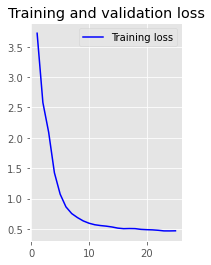

In [ ]:
plot_history(history)

4 - Conventional nn

In [ ]:
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(Conv1D(1024, 7, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Conv1D(1024, 5, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Conv1D(1024, 3, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model1.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 200, 1024)         1434624   
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 1024)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 1024)         5243904   
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 1024)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 1024)          3146752   
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 1024)        

In [ ]:
epochs = 10
batch_size = 1024

callback_training = CheckCallback()

#history = model1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])

Epoch 1/10
139/139 [==============================] - 203s 1s/step - loss: 5.0650 - mse: 5.0650 - val_loss: 2.7625 - val_mse: 2.7625
Epoch 2/10
139/139 [==============================] - 202s 1s/step - loss: 2.6885 - mse: 2.6885 - val_loss: 2.7165 - val_mse: 2.7165
Epoch 3/10
139/139 [==============================] - 202s 1s/step - loss: 2.5895 - mse: 2.5895 - val_loss: 2.9172 - val_mse: 2.9172
Epoch 4/10
139/139 [==============================] - 202s 1s/step - loss: 2.4612 - mse: 2.4612 - val_loss: 2.8031 - val_mse: 2.8031
Epoch 5/10
139/139 [==============================] - 202s 1s/step - loss: 2.1962 - mse: 2.1962 - val_loss: 2.8947 - val_mse: 2.8947
Epoch 6/10
139/139 [==============================] - 202s 1s/step - loss: 1.6111 - mse: 1.6111 - val_loss: 3.2542 - val_mse: 3.2542
Epoch 7/10
139/139 [==============================] - 202s 1s/step - loss: 1.0216 - mse: 1.0216 - val_loss: 3.3774 - val_mse: 3.3774
Epoch 8/10
139/139 [==============================] - 202s 1s/step - 

In [ ]:
mean_squared_error(y_test, model1.predict(X_test), squared=False)

1.7884631585294615

In [ ]:
history.history

{'loss': [5.0649590492248535,
  2.6884636878967285,
  2.5895116329193115,
  2.4611799716949463,
  2.196201801300049,
  1.6110690832138062,
  1.0215753316879272,
  0.723929762840271,
  0.5981748700141907,
  0.5542533993721008],
 'mse': [5.0649590492248535,
  2.6884636878967285,
  2.5895116329193115,
  2.4611799716949463,
  2.196201801300049,
  1.6110690832138062,
  1.0215753316879272,
  0.723929762840271,
  0.5981748700141907,
  0.5542533993721008],
 'val_loss': [2.762478828430176,
  2.7164950370788574,
  2.917217969894409,
  2.803102970123291,
  2.894699811935425,
  3.2541651725769043,
  3.377354860305786,
  3.2635505199432373,
  3.2789523601531982,
  3.278765916824341],
 'val_mse': [2.762478828430176,
  2.7164950370788574,
  2.917217969894409,
  2.803102970123291,
  2.894699811935425,
  3.2541651725769043,
  3.377354860305786,
  3.2635505199432373,
  3.2789523601531982,
  3.278765916824341]}

In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  5.064959    1.636355
1  2.688464    1.623224
2  2.589512    1.684374
3  2.461180    1.644683
4  2.196202    1.671452
5  1.611069    1.783030
6  1.021575    1.810492
7  0.723930    1.785657
8  0.598175    1.789436
9  0.554253    1.788463

In [ ]:
callback_training.df_test_array_summary.to_csv('history_gypotesis_4_conventional.csv')

No handles with labels found to put in legend.


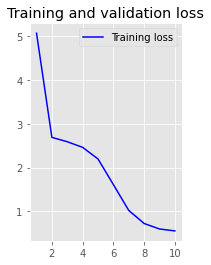

In [ ]:
plot_history(history)

5 - ltsm

In [ ]:
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add((LSTM(1024,return_sequences=True)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model1.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 200)          2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 1024)         5017600   
_________________________________________________________________
flatten_14 (Flatten)         (None, 204800)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               104858112 
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 111,876,225
Trainable params: 111,876,225
Non-trainable params: 0
_______________________________________

In [ ]:
epochs = 10
batch_size = 1024

callback_training = CheckCallback()

history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])

Epoch 1/10
139/139 [==============================] - 361s 3s/step - loss: 5.6054 - mse: 5.6054 - val_loss: 2.6886 - val_mse: 2.6886
Epoch 2/10
139/139 [==============================] - 360s 3s/step - loss: 2.6300 - mse: 2.6300 - val_loss: 2.7014 - val_mse: 2.7014
Epoch 3/10
139/139 [==============================] - 360s 3s/step - loss: 2.5192 - mse: 2.5192 - val_loss: 2.7300 - val_mse: 2.7300
Epoch 4/10
139/139 [==============================] - 360s 3s/step - loss: 2.3323 - mse: 2.3323 - val_loss: 2.8376 - val_mse: 2.8376
Epoch 5/10
139/139 [==============================] - 360s 3s/step - loss: 2.0771 - mse: 2.0771 - val_loss: 3.0239 - val_mse: 3.0239
Epoch 6/10
139/139 [==============================] - 359s 3s/step - loss: 1.8216 - mse: 1.8216 - val_loss: 3.2446 - val_mse: 3.2446
Epoch 7/10
139/139 [==============================] - 361s 3s/step - loss: 1.5876 - mse: 1.5876 - val_loss: 3.5145 - val_mse: 3.5145
Epoch 8/10
139/139 [==============================] - 361s 3s/step - 

In [ ]:
mean_squared_error(y_test, model1.predict(X_test), squared=False)

1.989025358062674

In [ ]:
callback_training.df_test_array_summary.to_csv('history_gypotesis_5_ltsm.csv')

In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  5.605433    1.613701
1  2.630049    1.616885
2  2.519215    1.626889
3  2.332259    1.663842
4  2.077075    1.718935
5  1.821645    1.784407
6  1.587559    1.858844
7  1.382905    1.868223
8  1.220002    1.931778
9  1.079430    1.989025

No handles with labels found to put in legend.


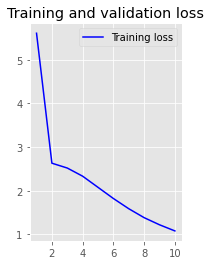

In [ ]:
plot_history(history)

6 - Ensemble of simple nn

In [ ]:
def model_g_3_easy_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model1.add(Flatten())
  model1.add(Dense(100, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1

In [ ]:
epochs = 1
batch_size = 1024

callback_training = CheckCallback()

array_model_g_3 = []

for i in range(10):
  model1 = model_g_3_easy_create()
  history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])
  array_model_g_3.append(model1)

139/139 [==============================] - 16s 118ms/step - loss: 3.6855 - mse: 3.6855 - val_loss: 2.7152 - val_mse: 2.7152


In [ ]:
array_model_g_3

In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  3.712619    1.618335
1  3.681103    1.616426
2  3.762398    1.617119
3  3.653245    1.615644
4  3.709906    1.629566
5  3.415430    1.626308
6  3.472382    1.612982
7  3.770433    1.620252
8  3.571014    1.614946
9  3.685491    1.621523

In [ ]:
df_g_3_predict = pd.DataFrame({"model_0" : array_model_g_3[0].predict(X_test).flatten()})

for i in range(1,10):
  df_g_3_predict.insert(0, "model_" + str(i), pd.DataFrame(array_model_g_3[i].predict(X_test).flatten()), True) 

In [ ]:
results_with_number_of_model = pd.DataFrame()

for i in range(1, 10):
  temp = df_g_3_predict["model_0"]
  for j in range(1, i+1):
    temp = temp + df_g_3_predict["model_" + str(i)]
  temp = temp / (int(j)+1)
  df_g_3_predict['model_mean_' + str(i)] = temp
  results_with_number_of_model = results_with_number_of_model.append({'number':(int(j)+1), 'error':mean_squared_error(y_test, temp, squared=False)},ignore_index=True)

In [ ]:
results_with_number_of_model

error  number
0  1.616167     2.0
1  1.615604     3.0
2  1.615081     4.0
3  1.625769     5.0
4  1.620566     6.0
5  1.612508     7.0
6  1.619400     8.0
7  1.614547     9.0
8  1.620684    10.0

In [ ]:
df_g_3_predict.to_csv('df_g_3_predict.csv')

7 - Ensemble of conventional nn

In [ ]:
def model_g_4_easy_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model1.add(Conv1D(1024, 7, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 5, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 3, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Flatten())
  model1.add(Dense(512, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1

In [ ]:
epochs = 1
batch_size = 1024

callback_training = CheckCallback()

array_model_g_4 = []

for i in range(10):
  model1 = model_g_4_easy_create()
  history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])
  array_model_g_4.append(model1)

139/139 [==============================] - 202s 1s/step - loss: 5.3006 - mse: 5.3006 - val_loss: 2.7959 - val_mse: 2.7959


In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  5.749150    1.635094
1  5.448050    1.634448
2  5.131798    1.635620
3  5.787239    1.631526
4  5.468624    1.626576
5  5.677347    1.631369
6  5.059451    1.630517
7  5.214302    1.633460
8  5.406875    1.631932
9  5.300647    1.646849

In [ ]:
df_g_4_predict = pd.DataFrame({"model_0" : array_model_g_4[0].predict(X_test).flatten()})

for i in range(1,10):
  df_g_4_predict.insert(0, "model_" + str(i), pd.DataFrame(array_model_g_4[i].predict(X_test).flatten()), True) 

In [ ]:
results_with_number_of_model = pd.DataFrame()

for i in range(1, 10):
  temp = df_g_4_predict["model_0"]
  for j in range(1, i+1):
    temp = temp + df_g_4_predict["model_" + str(i)]
  temp = temp / (int(j)+1)
  df_g_4_predict['model_mean_' + str(i)] = temp
  results_with_number_of_model = results_with_number_of_model.append({'number':(int(j)+1), 'error':mean_squared_error(y_test, temp, squared=False)},ignore_index=True)

In [ ]:
results_with_number_of_model

error  number
0  1.626783     2.0
1  1.632358     3.0
2  1.630139     4.0
3  1.625738     5.0
4  1.629642     6.0
5  1.628422     7.0
6  1.630945     8.0
7  1.630965     9.0
8  1.640433    10.0

In [ ]:
df_g_4_predict.to_csv('df_g_4_predict.csv')

8 - Ensemble of recurrent nn

In [ ]:
def model_g_5_easy_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model1.add((LSTM(1024,return_sequences=True)))
  model1.add(Flatten())
  model1.add(Dense(512, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1

In [ ]:
epochs = 1
batch_size = 1024

callback_training = CheckCallback()

array_model_g_5 = []

for i in range(10):
  model1 = model_g_5_easy_create()
  history = model1.fit(X_train, y_train, epochs=epochs, callbacks=[callback_training])
  array_model_g_5.append(model1)

4923/4923 [==============================] - 582s 118ms/step - loss: 2.9803 - mse: 2.9803


In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  3.005131    1.635389
1  3.005646    1.630569
2  2.989852    1.669207
3  2.982972    1.626327
4  2.971843    1.674604
5  2.983014    1.625984
6  3.022427    1.632493
7  2.997567    1.654609
8  2.995261    1.745781
9  2.980295    1.826644

In [ ]:
df_g_5_predict = pd.DataFrame({"model_0" : array_model_g_5[0].predict(X_test).flatten()})

for i in range(1,10):
  df_g_5_predict.insert(0, "model_" + str(i), pd.DataFrame(array_model_g_5[i].predict(X_test).flatten()), True) 

In [ ]:
results_with_number_of_model = pd.DataFrame()

for i in range(1, 10):
  temp = df_g_5_predict["model_0"]
  for j in range(1, i+1):
    temp = temp + df_g_5_predict["model_" + str(i)]
  temp = temp / (int(j)+1)
  df_g_5_predict['model_mean_' + str(i)] = temp
  results_with_number_of_model = results_with_number_of_model.append({'number':(int(j)+1), 'error':mean_squared_error(y_test, temp, squared=False)},ignore_index=True)

In [ ]:
results_with_number_of_model

error  number
0  1.623600     2.0
1  1.649323     3.0
2  1.620651     4.0
3  1.656706     5.0
4  1.622794     6.0
5  1.629318     7.0
6  1.648421     8.0
7  1.724543     9.0
8  1.795380    10.0

In [ ]:
df_g_5_predict.to_csv('df_g_5_predict.csv')

9 - Ensemble of hypothesis 3,4,5

In [ ]:
df_g_3_predict = pd.read_csv('df_g_3_predict.csv')
df_g_4_predict = pd.read_csv('df_g_4_predict.csv')
df_g_5_predict = pd.read_csv('df_g_5_predict.csv')

In [ ]:
mean_squared_error(y_test, (df_g_5_predict['model_mean_9'] + df_g_4_predict['model_mean_9'] + df_g_3_predict['model_mean_9']) / 3, squared=False)

1.6553120045607852

10 - GPT-2: pretrained model 355M. (run separately with the previous ones)

In [ ]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

In [ ]:
train = pandas.read_csv('clear.csv')

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(train['overview'], train['vote_average'], test_size=0.2, random_state=seed)

In [ ]:
X_train

142264    Look, it's about a ham sandwich that takes you...
133317    Villainous Gru lives up to his reputation as a...
90529     Three of Reagan High School's most popular gir...
1523      Asian remake of Employees Leaving the Lumiere ...
4887      The likeable and carefree Grand Duke of Abacco...
                                ...                        
151535    After playing a pagan ritual on a dare, a grou...
55293     Obayashi’s take on the famous Kosuke Kindaichi...
49751     A Blaxploitation flick where four karate exper...
136767    An Amish man comes to Hollywood to be a missio...
176991    After an assault leaves Amanda pregnant and ou...
Name: overview, Length: 157527, dtype: object

In [ ]:
df_to_one_text = pd.DataFrame({'overview': X_train, 'vote_average':y_train}).reset_index()

In [ ]:
df_to_one_text

index                                           overview  vote_average
0       142264  Look, it's about a ham sandwich that takes you...           6.5
1       133317  Villainous Gru lives up to his reputation as a...           7.2
2        90529  Three of Reagan High School's most popular gir...           6.2
3         1523  Asian remake of Employees Leaving the Lumiere ...           5.3
4         4887  The likeable and carefree Grand Duke of Abacco...           7.3
...        ...                                                ...           ...
157522  151535  After playing a pagan ritual on a dare, a grou...           3.4
157523   55293  Obayashi’s take on the famous Kosuke Kindaichi...           6.0
157524   49751  A Blaxploitation flick where four karate exper...           5.0
157525  136767  An Amish man comes to Hollywood to be a missio...           1.9
157526  176991  After an assault leaves Amanda pregnant and ou...           6.0

[157527 rows x 3 columns]

to text

In [ ]:
text = ""
for index, row in df_to_one_text.iterrows():
    if index % 1000 == 0:
        print(index)
    text = text + " " + str(row['overview']) + " - vote - " + str(row['vote_average'])+ ". "

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000


In [ ]:
#write
f = open('text_stepik_ex_3.txt', 'w', encoding='utf-8')
f.write(str(text))

In [ ]:
gpt2.download_gpt2(model_name="355M")

Fetching checkpoint: 1.05Mit [00:00, 265Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 106Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 459Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:10, 136Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 287Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 133Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 194Mit/s]                                                       


In [ ]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset='text_stepik_ex_3.txt',
              model_name='355M',
              steps=5000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Loading checkpoint models/355M/model.ckpt
INFO:tensorflow:Restoring parameters from models/355M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:51<00:00, 51.47s/it]


dataset has 10868940 tokens
Training...
[10 | 17.48] loss=3.32 avg=3.32
[20 | 26.31] loss=3.09 avg=3.20
[30 | 35.13] loss=3.31 avg=3.24
[40 | 43.96] loss=3.12 avg=3.21
[50 | 52.81] loss=3.13 avg=3.19
[60 | 61.65] loss=3.11 avg=3.18
[70 | 70.49] loss=3.21 avg=3.18
[80 | 79.32] loss=2.97 avg=3.15
[90 | 88.14] loss=3.06 avg=3.14
[100 | 96.97] loss=3.35 avg=3.17
[110 | 105.81] loss=3.04 avg=3.15
[120 | 114.63] loss=3.12 avg=3.15
[130 | 123.47] loss=3.03 avg=3.14
[140 | 132.31] loss=3.48 avg=3.17
[150 | 141.14] loss=3.14 avg=3.16
[160 | 149.97] loss=3.09 avg=3.16
[170 | 158.80] loss=3.04 avg=3.15
[180 | 167.63] loss=3.28 avg=3.16
[190 | 176.46] loss=3.45 avg=3.18
[200 | 185.30] loss=3.10 avg=3.17
======== SAMPLE 1 ========
 experimental research of a woman who has an abnormal child, with whom she cannot make happy. To cope with this tragedy, the wife of the boy, a beautiful and intelligent woman, disappears. An American in command of the unit investigates the circumstances, and he finds tha

In [ ]:
df_test_one_text = pd.DataFrame({'overview': X_test, 'vote_average':y_test}).reset_index()

In [ ]:
for index, row in df_test_one_text.iterrows():
    if index % 1000 == 0:
        print(index)
    print(str(row['overview']) + " - vote - ")
    single_text = gpt2.generate(sess,
              prefix=str(row['overview']) + " - vote - ",
              length=5,
              temperature=0.7,
              top_p=0.9,
              nsamples=5,
              batch_size=5
              )
    print(single_text)
    break

0
The head monk orders a young acolyte to guard a beautiful cherry tree in the monastery garden while he goes out. But the older man underestimates his colleague’s fondness for sake. - vote - 
The head monk orders a young acolyte to guard a beautiful cherry tree in the monastery garden while he goes out. But the older man underestimates his colleague’s fondness for sake. - vote -  The story of a father
The head monk orders a young acolyte to guard a beautiful cherry tree in the monastery garden while he goes out. But the older man underestimates his colleague’s fondness for sake. - vote -  A documentary about the life
The head monk orders a young acolyte to guard a beautiful cherry tree in the monastery garden while he goes out. But the older man underestimates his colleague’s fondness for sake. - vote -  An agitator tries
The head monk orders a young acolyte to guard a beautiful cherry tree in the monastery garden while he goes out. But the older man underestimates his colleague’s fon

11(test) - Ensemble of conventional nn(10 epoch)

In [ ]:
def model_g_4_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  # model1.add((LSTM(512,return_sequences=True)))
  # model1.add(Dense(100, activation='relu'))
  model1.add(Conv1D(1024, 7, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 5, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 3, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Flatten())
  model1.add(Dense(512, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1

In [ ]:
epochs = 10
batch_size = 1024

callback_training = CheckCallback()

array_model_g_4 = []

for i in range(10):
  model1 = model_g_4_create()
  history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])
  array_model_g_4.append(model1)

Epoch 1/10
139/139 [==============================] - 121s 873ms/step - loss: 4.8960 - mse: 4.8960 - val_loss: 2.7379 - val_mse: 2.7379
Epoch 2/10
139/139 [==============================] - 119s 857ms/step - loss: 2.6855 - mse: 2.6855 - val_loss: 2.7159 - val_mse: 2.7159
Epoch 3/10
139/139 [==============================] - 119s 856ms/step - loss: 2.5805 - mse: 2.5805 - val_loss: 2.7730 - val_mse: 2.7730
Epoch 4/10
139/139 [==============================] - 119s 856ms/step - loss: 2.4268 - mse: 2.4268 - val_loss: 2.8545 - val_mse: 2.8545
Epoch 5/10
139/139 [==============================] - 119s 857ms/step - loss: 2.0481 - mse: 2.0481 - val_loss: 3.0072 - val_mse: 3.0072
Epoch 6/10
139/139 [==============================] - 119s 856ms/step - loss: 1.3456 - mse: 1.3456 - val_loss: 3.2275 - val_mse: 3.2275
Epoch 7/10
139/139 [==============================] - 119s 857ms/step - loss: 0.8834 - mse: 0.8834 - val_loss: 3.2912 - val_mse: 3.2912
Epoch 8/10
139/139 [============================

In [ ]:
callback_training.df_test_array_summary

loss  test_error
0   4.896027    1.628355
1   2.685539    1.622248
2   2.580512    1.639390
3   2.426752    1.662757
4   2.048107    1.712139
..       ...         ...
95  1.571270    1.763135
96  1.059101    1.812067
97  0.730481    1.785792
98  0.583145    1.801995
99  0.531025    1.780574

[100 rows x 2 columns]

In [ ]:
df_g_4_predict = pd.DataFrame({"model_0" : array_model_g_4[0].predict(X_test).flatten()})

for i in range(1,10):
  df_g_4_predict.insert(0, "model_" + str(i), pd.DataFrame(array_model_g_4[i].predict(X_test).flatten()), True) 

In [ ]:
results_with_number_of_model = pd.DataFrame()

for i in range(1, 10):
  temp = df_g_4_predict["model_0"]
  for j in range(1, i+1):
    temp = temp + df_g_4_predict["model_" + str(i)]
  temp = temp / (int(j)+1)
  df_g_4_predict['model_mean_' + str(i)] = temp
  results_with_number_of_model = results_with_number_of_model.append({'number':(int(j)+1), 'error':mean_squared_error(y_test, temp, squared=False)},ignore_index=True)

In [ ]:
results_with_number_of_model

error  number
0  1.728371     2.0
1  1.714412     3.0
2  1.715692     4.0
3  1.757417     5.0
4  1.758459     6.0
5  1.738793     7.0
6  1.751064     8.0
7  1.745128     9.0
8  1.759114    10.0

In [ ]:
df_g_4_predict.to_csv('df_g_4_predict_epoch_10.csv')

Code for app

In [ ]:
import os

In [ ]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add((LSTM(100,return_sequences=True)))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 100)          120400    
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               2000100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 4,120,601
Trainable params: 4,120,601
Non-trainable params: 0
____________________________________________

In [ ]:
epochs = 5
batch_size = 1024

callback_training = CheckCallback()

history = model2.fit(X_train, y_train, epochs=epochs, callbacks=[callback_training])

Epoch 1/5
4923/4923 [==============================] - 380s 77ms/step - loss: 3.0081 - mse: 3.0081
Epoch 2/5
4923/4923 [==============================] - 375s 76ms/step - loss: 2.6543 - mse: 2.6543
Epoch 3/5
4923/4923 [==============================] - 378s 77ms/step - loss: 2.1269 - mse: 2.1269
Epoch 4/5
4923/4923 [==============================] - 371s 75ms/step - loss: 1.7008 - mse: 1.7008
Epoch 5/5
4923/4923 [==============================] - 366s 74ms/step - loss: 1.4205 - mse: 1.4205


In [ ]:
callback_training.df_test_array_summary

loss  test_error
0  3.008142    1.613955
1  2.654348    1.654466
2  2.126861    1.723705
3  1.700795    1.787177
4  1.420518    1.834349

In [ ]:
model2.save_weights('test_model2')
statinfo = os.stat('test_model2.data-00000-of-00001')
statinfo.st_size

49451185

In [ ]:
train['overview'][196908]

'Lance and Spenser, 10 years after ending the Adam Driver Fan Cast, have to discover the lost tape to save the world. Across their journey they get robbed, stopped by a cop, and trip in a world of legos'

In [ ]:
seq = tokenizer.texts_to_sequences(["Lance and Spenser, 10 yearsфывафывафыва after ending the Adam Driver Fan Cast, have to discover the lost tape to save the world. Across their journey they get robbed, stopped by a cop, and trip in a world of legos"])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

pred1 = model2.predict(padded)
print(pred1)

[[8.360485]]


save tokenizer

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)